# EECS731
## Project 3 - Weekend Movie Trip

Blockbuster or art film?
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the one of the MovieLens datasets from https://grouplens.org/datasets/movielens/
3. Load the data set into panda data frames
4. Formulate one or two ideas on how the combination of ratings and tags by users helps the data set to establish additional value using exploratory data analysis
5. Build one or more clustering models to determine similar movies to recommend using the other ratings and tags of movies by other users as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub
<br>
***

In [1]:
from pandas import read_csv, Series, pivot_table, get_dummies, concat
from re import sub
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from numpy import zeros
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from matplotlib.pyplot import figure , imshow, axis, show
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure , imshow, axis, show, plot, title, xlabel, ylabel
import numpy as np
from numpy import *
import numpy.matlib

In [2]:
df_movies = read_csv("../data/raw/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
df_movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [5]:
df_ratings = read_csv("../data/raw/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
df_ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [8]:
df_tags = read_csv("../data/raw/tags.csv")
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [10]:
df_tags.isnull().any()

userId       False
movieId      False
tag          False
timestamp    False
dtype: bool

***Let's look deeper at the datasets given***<br>
*column_name (type of column) 
    - description*


The movies dataset contains the following columns :
- movieId (int) 
    - A unique id for each movie
- title (str) 
    - Name of the movie
- genres (str) 
    - Genre/s seperated by |
    - ***should probably use explode***
    
The ratings dataset contains the following columns :
- userId (int)
    - Unique id for each user
- movieId (int) 
    - A unique id for each movie
- rating (float)
    - ratings of a movie given by a user
    - On a 0-5 ratings
- timestamp (int) 
    - seconds of when the ratings is posted

The tags dataset contains the following columns :
- userId (int)
    - Unique id for each user
- movieId (int) 
    - A unique id for each movie
- tags (float)
    - tags related to movie
- timestamp (int) 
    - seconds of when the ratings is posted   
<br>
- No nulls rows

***

## Further data exploration!

In [11]:
print(f"There are {len(df_tags.userId.unique())} unique users")
print(f"Unique users are {df_tags.userId.unique()} \n")

print(f"There are {len(df_tags.tag.unique())} unique tags")
print(f"Unique tags are {df_tags.tag.unique()} \n")

print(f"There are {len(df_movies.movieId.unique())} unique movie")
print(f"Unique movieId are {df_movies.movieId.unique()} \n")

print(df_movies.title.unique()[49:60])

There are 58 unique users
Unique users are [  2   7  18  21  49  62  63  76 103 106 112 119 125 132 138 161 166 167
 177 184 193 205 226 256 274 288 289 291 300 305 318 319 327 336 341 356
 357 419 424 435 439 462 474 477 487 506 509 513 520 533 537 543 567 573
 599 600 606 610] 

There are 1589 unique tags
Unique tags are ['funny' 'Highly quotable' 'will ferrell' ... 'gun fu' 'heroic bloodshed'
 'Heroic Bloodshed'] 

There are 9742 unique movie
Unique movieId are [     1      2      3 ... 193585 193587 193609] 

['Big Green, The (1995)' 'Georgia (1995)' 'Home for the Holidays (1995)'
 'Postman, The (Postino, Il) (1994)' 'Indian in the Cupboard, The (1995)'
 'Eye for an Eye (1996)' "Mr. Holland's Opus (1995)"
 "Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)"
 'Two if by Sea (1996)' 'Bio-Dome (1996)'
 'Lawnmower Man 2: Beyond Cyberspace (1996)']


***Notice We want to delete year and , The in df_movie's title***

In [12]:
df_movies['title'] = df_movies['title'].str.replace(r"\(.*?\)","")
df_movies['title'] = df_movies['title'].str.split(",").str[0]
df_movies = df_movies.apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)

df_movies.head()

,movieId,title,genres
0,1,toy story,adventure|animation|children|comedy|fantasy
1,2,jumanji,adventure|children|fantasy
2,3,grumpier old men,comedy|romance
3,4,waiting to exhale,comedy|drama|romance
4,5,father of the bride part ii,comedy


***Notice 'heroic bloodshed', 'Heroic Bloodshed' in unique tags. We have to make it all lower case***

In [13]:
# Remove all white spaces and change to lower case if col type is str
df_tags = df_tags.apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)

# remove punctutations
df_tags['tag'] = df_tags['tag'].apply(lambda x: sub(r'[^\w\s]','', x))
# remove non-ascii
df_tags['tag'] = df_tags['tag'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)]))
 
print(f"There are {len(df_tags.tag.unique())} unique tags")
print(f"Unique tags are {df_tags.tag.unique()} \n")

df_ratings = df_ratings.apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)

There are 1471 unique tags
Unique tags are ['funny' 'highly quotable' 'will ferrell' ... 'austere' 'gun fu'
 'heroic bloodshed'] 



***Delete the useless timestamp columns***

In [14]:
# Data cleaning
df_ratings.drop("timestamp", axis=1, inplace=True)
df_tags.drop("timestamp", axis=1, inplace=True)

***Change Col to list***<br>
   First,Split the | to new columns

In [15]:
df_genre_vector= df_movies["genres"].str.replace("|", " ")

df_genre_vector.head()

0    adventure animation children comedy fantasy
1                     adventure children fantasy
2                                 comedy romance
3                           comedy drama romance
4                                         comedy
Name: genres, dtype: object

In [16]:
df_movies["genres"] = df_genre_vector

df_movies.head()

,movieId,title,genres
0,1,toy story,adventure animation children comedy fantasy
1,2,jumanji,adventure children fantasy
2,3,grumpier old men,comedy romance
3,4,waiting to exhale,comedy drama romance
4,5,father of the bride part ii,comedy


***Combine tags with same userid and movieid into one row and Save to list***

In [17]:
df_tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,highly quotable
2,2,60756,will ferrell
3,2,89774,boxing story
4,2,89774,mma


First, we have to group them according to the same userid and movieid to combine the tag to one row

In [18]:
df_grouped_tags = df_tags.groupby(["userId","movieId"])
df_grouped_tags = df_grouped_tags["tag"].apply(lambda x: ",".join(x)).reset_index()

df_grouped_tags

,userId,movieId,tag
0,2,60756,"funny,highly quotable,will ferrell"
1,2,89774,"boxing story,mma,tom hardy"
2,2,106782,"drugs,leonardo dicaprio,martin scorsese"
3,7,48516,way too long
4,18,431,"al pacino,gangster,mafia"
...,...,...,...
1770,606,6107,world war ii
1771,606,7382,for katie
1772,606,7936,austere
1773,610,3265,"gun fu,heroic bloodshed"


In [19]:
df_grouped_tags['tag'] = df_grouped_tags["tag"].map(lambda x: x.split(','))
# Replace the old dataframe with the new one
df_tags = df_grouped_tags
df_tags

,userId,movieId,tag
0,2,60756,"[funny, highly quotable, will ferrell]"
1,2,89774,"[boxing story, mma, tom hardy]"
2,2,106782,"[drugs, leonardo dicaprio, martin scorsese]"
3,7,48516,[way too long]
4,18,431,"[al pacino, gangster, mafia]"
...,...,...,...
1770,606,6107,[world war ii]
1771,606,7382,[for katie]
1772,606,7936,[austere]
1773,610,3265,"[gun fu, heroic bloodshed]"


## Which columns to merge with? 
All three dataframe can be merge with the "movieId" column

In [20]:
df = df_ratings.merge(df_tags, on=["userId","movieId"], how="inner")
df.head()

,userId,movieId,rating,tag
0,2,60756,5.0,"[funny, highly quotable, will ferrell]"
1,2,89774,5.0,"[boxing story, mma, tom hardy]"
2,2,106782,5.0,"[drugs, leonardo dicaprio, martin scorsese]"
3,7,48516,1.0,[way too long]
4,18,431,4.0,"[al pacino, gangster, mafia]"


In [21]:
df = df.merge(df_movies, on=["movieId"], how="inner")
df.reset_index(drop=True, inplace=True)
df.tail()

,userId,movieId,rating,tag,title,genres
1630,606,1357,4.0,[music],shine,drama romance
1631,606,1948,3.5,[british],tom jones,adventure comedy romance
1632,606,5694,3.0,[70mm],staying alive,comedy drama musical
1633,606,6107,4.0,[world war ii],night of the shooting stars,drama war
1634,610,3265,5.0,"[gun fu, heroic bloodshed]",hard-boiled,action crime drama thriller


In [22]:
def clean_and_tokenize(doc: list):
    
    values_inside_list = " ".join(doc)
    # Seperate "Hello world" to ["Hello", "world"]
    tokens = word_tokenize(values_inside_list.lower())
    # Remove tokens that is not alpha and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stopwords.words('english')]
    return tokens

tagged_docs = []
for index, list_of_words in enumerate(df.tag.values):
    temp_tagged_document = TaggedDocument(clean_and_tokenize(list_of_words), tags=[index])
    tagged_docs.append(temp_tagged_document)

## Let's make our doc2vec model

In [23]:
max_epochs = 50
vec_size = 20
alpha = 0.025
min_alpha = 0.00025
min_count = 1
dm = 0 # If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used

doc2vec_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=min_alpha, min_count=min_count, dm=dm) 
doc2vec_model.build_vocab(tagged_docs)

## Train our doc2vec model with max_epochs (50)

In [24]:
for epoch in range(max_epochs):
    doc2vec_model.train(tagged_docs, 
                        total_examples = doc2vec_model.corpus_count, 
                        epochs = doc2vec_model.epochs)
    # Reduce the alpa to try to reduce the model learning rate
    doc2vec_model.alpha -= 0.0002
    # No Decay as we fixed the learning rate
    doc2vec_model.min_alpha = doc2vec_model.alpha

# TEST OUT DOC2VEC RECOMMENDER SYSTEM

***Change the list below to try***

***We want to seperate the year from the title and delete the year after the extracting the year***

In [25]:
# Change only this line
movie_that_user_has_watched = ["toy story"]


print(f"User has watched this/ese movies: ")
print(*movie_that_user_has_watched, sep="\n")

User has watched this/ese movies: 
toy story


In [26]:
list_movie_index = []
for movie in movie_that_user_has_watched:
    df_index = df[df["title"] == movie].index.values[0] 
    list_movie_index.append(df_index)


# Use cosine similarity to find out which movie is similar
movie_by_doc2vec = doc2vec_model.docvecs.most_similar(positive = list_movie_index , topn = 10)

# Clean the output given by doc2vec
# To make sure that there is no duplicate value
unique_recommended_movie = set() 
for i, _ in list(set(movie_by_doc2vec)):
    movie_name = df.loc[int(i), "title"]
    if movie_name in movie_that_user_has_watched:
        continue
    unique_recommended_movie.add(movie_name)

print("DOC2VEC RECOMMENDER SYSTEM RECOMMENDS:\n")
print(*unique_recommended_movie, sep="\n")

DOC2VEC RECOMMENDER SYSTEM RECOMMENDS:

big
children of the damned
holes
bad seed
official story
bug's life
up
village of the damned
toy story 2


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.cluster import KMeans
count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'), max_features=100)
vectorizer_genres = count_vectorizer.fit_transform(df["genres"])
print(type(vectorizer_genres))
vectorizer_genres.toarray()

<class 'scipy.sparse.csr.csr_matrix'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [28]:
df_temp = df.loc[:, (df.columns != 'title') & (df.columns != 'genres') & (df.columns != 'tag')]
df_temp.head()

,userId,movieId,rating
0,2,60756,5.0
1,62,60756,3.5
2,424,60756,4.0
3,2,89774,5.0
4,2,106782,5.0


In [29]:
X = hstack([csr_matrix(df_temp),vectorizer_genres])
X # input

<1635x26 sparse matrix of type '<class 'numpy.float64'>'
	with 9118 stored elements in COOrdinate format>

In [30]:
Y = df.title.values
Y # output

array(['step brothers', 'step brothers', 'step brothers', ...,
       'staying alive', 'night of the shooting stars', 'hard-boiled'],
      dtype=object)

In [42]:
def elbow_method(X, max_category): 
    inertia_list =[]
    ks = list(range(1,max_category))
    # Assume the max number of cluster would be 10
    for k in ks:
        kmeans = KMeans(n_clusters= k, init='random')
        kmeans.fit(X)
        inertia_list.append(kmeans.inertia_)
    
    def get_elbow_curve(y_axis_list):
        # get the list of coordinates
        num_points = len(y_axis_list)
        # add index to the errors by combining them [ [range(0,19)], [Errors] ]
        all_coords = np.vstack((range(num_points), y_axis_list))
        # Tranform into [ [0, Errors[0], [..,..]]]
        all_coords = all_coords.T

        #get the vector line that we will be comparing to
        vector = all_coords[-1] - all_coords[0]
        # Eculidian Norm 
        vector_norm = vector / np.sqrt(np.sum(vector**2))


        vector_from_first_point = all_coords - all_coords[0]
        # repmat to produce the vector_norm 18 times and * vector and rmbrt to add axis 1 to remain [ ... ,... ]
        dot_product = np.sum(vector_from_first_point * np.matlib.repmat(vector_norm, num_points, 1), axis=1)
        #  a = [a0, a1, ..., aM] , b = [b0, b1, ..., bN][
        # [a0*b0  a0*b1 ... a0*bN ]
        # [a1*b0    .
        #[ ...          .
        #[aM*b0            aM*bN ]] returns out[i,j] = a[i]*b[j]
        vec_from_first_parallel = np.outer(dot_product, vector_norm)


        vector_to_line = vector_from_first_point - vec_from_first_parallel
        distance_to_line = np.sqrt(np.sum(vector_to_line ** 2, axis=1))
        best_index = np.argmax(distance_to_line)
        return best_index
    
    # Find the elbow with our function
    elbow_index_of_k_mean = get_elbow_curve(inertia_list)
    plot( ks , inertia_list , "-x")
    plot( ks[elbow_index_of_k_mean] , inertia_list[elbow_index_of_k_mean],"-o")
    title('The Elbow Method')
    xlabel("Number of clusters, K")
    ylabel("Inertia")
    show()


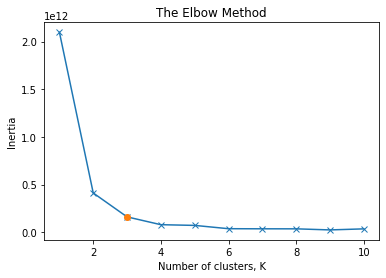

In [50]:
elbow_method(X,11)

Like our function suggest k=3, we can try k=3

In [53]:
def k_mean_cluster(k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)
    
    kmeans_pred_labels = kmeans.labels_
    kmeans_cm = confusion_matrix(labels, kmeans_pred_labels)
    print(f"K={k} KMean confusion matrix:")
    print(kmeans_cm)
    kmeans_acc = accuracy_score(labels,kmeans_pred_labels)
    print(f"K={k} KMean accuracy: " + str(kmeans_acc) +"\n")

In [54]:
k_mean_cluster(3)

K=3 KMean confusion matrix:
[[ 187    0    0]
 [   0 1321    0]
 [   0    0  127]]
K=3 KMean accuracy: 1.0



## Summary

DOC2VEC Model works better because KMean gives us an accuracy of 1.0 (which is a problem)